In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
%matplotlib inline

In [2]:
data = pd.read_csv("water_potability.csv")

In [3]:
print("Dataset loaded successfully!")
print("Shape before cleaning:", data.shape)
print("\nMissing values before cleaning:\n", data.isnull().sum())

Dataset loaded successfully!
Shape before cleaning: (3276, 10)

Missing values before cleaning:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


In [4]:
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
print("\nMissing values handled using KNN Imputer.")
print("Missing values after imputation:\n", data_imputed.isnull().sum())


Missing values handled using KNN Imputer.
Missing values after imputation:
 ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


In [5]:
for col in data_imputed.columns[:-1]:  # Skip 'Potability' column
    Q1 = data_imputed[col].quantile(0.25)
    Q3 = data_imputed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    data_imputed[col] = np.clip(data_imputed[col], lower_limit, upper_limit)

print("\nOutliers capped using IQR method.")


Outliers capped using IQR method.


In [6]:
data_imputed['ph'] = data_imputed['ph'].clip(lower=0, upper=14)

In [7]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_imputed.drop('Potability', axis=1))

data_scaled = pd.DataFrame(scaled_features, columns=data_imputed.columns[:-1])
data_scaled['Potability'] = data_imputed['Potability']

print("\nFeatures scaled using StandardScaler.")


Features scaled using StandardScaler.


In [8]:
#Removes repeated rows if dataset had duplicates.
before = data_scaled.shape[0]
data_scaled = data_scaled.drop_duplicates()
after = data_scaled.shape[0]
print(f"\nRemoved {before - after} duplicate rows (if any).")


Removed 0 duplicate rows (if any).


In [9]:
data_scaled.to_csv("cleaned_water_potability.csv", index=False)
print("\nCleaned dataset saved as 'cleaned_water_potability.csv'")


Cleaned dataset saved as 'cleaned_water_potability.csv'


In [10]:
print("\nFinal Dataset Summary:")
print(data_scaled.describe())
print("\nFinal shape:", data_scaled.shape)


Final Dataset Summary:
                 ph      Hardness        Solids   Chloramines       Sulfate  \
count  3.276000e+03  3.276000e+03  3.276000e+03  3.276000e+03  3.276000e+03   
mean   1.127846e-16 -1.507409e-16 -2.271958e-16 -2.776235e-16 -7.894919e-16   
std    1.000153e+00  1.000153e+00  1.000153e+00  1.000153e+00  1.000153e+00   
min   -2.459160e+00 -2.476150e+00 -2.518320e+00 -2.575035e+00 -2.398398e+00   
25%   -6.201205e-01 -6.104492e-01 -7.321673e-01 -6.440698e-01 -5.990623e-01   
50%   -1.794576e-02  1.796822e-02 -1.198018e-01  5.508795e-03 -1.184244e-02   
75%    6.059060e-01  6.333513e-01  6.256933e-01  6.432406e-01  6.004946e-01   
max    2.444946e+00  2.499052e+00  2.662484e+00  2.574206e+00  2.399830e+00   

       Conductivity  Organic_carbon  Trihalomethanes     Turbidity  \
count  3.276000e+03    3.276000e+03     3.276000e+03  3.276000e+03   
mean  -9.353527e-16    1.735147e-17    -6.897210e-16 -7.157482e-17   
std    1.000153e+00    1.000153e+00     1.000153e+00  

In [11]:
data = pd.read_csv("cleaned_water_potability.csv")

In [12]:
X = data.drop('Potability', axis=1)
y = data['Potability']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% for testing
    random_state=42,     # Reproducible split
    stratify=y           # Maintain class balance
)

In [14]:
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels:", y_train.shape)
print("Testing labels:", y_test.shape)

Training data shape: (2620, 9)
Testing data shape: (656, 9)
Training labels: (2620,)
Testing labels: (656,)


In [15]:
def evaluate_model(y_true, y_pred, y_proba=None, model_name="Model"):
    print(f"\n Results for {model_name}")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
        print(f"ROC-AUC:   {auc:.4f}")

    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    print()
    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["Not Potable","Potable"], yticklabels=["Not Potable","Potable"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    print()
    # ROC Curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_true, y_proba):.3f})", color="blue")
        plt.plot([0,1],[0,1],'--',color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} - ROC Curve")
        plt.legend()
        plt.show()

Logistic Regression


 Results for Logistic Regression
Accuracy:  0.5229
Precision: 0.4112
Recall:    0.5156
F1-Score:  0.4575
ROC-AUC:   0.5438

Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.53      0.57       400
         1.0       0.41      0.52      0.46       256

    accuracy                           0.52       656
   macro avg       0.52      0.52      0.52       656
weighted avg       0.54      0.52      0.53       656




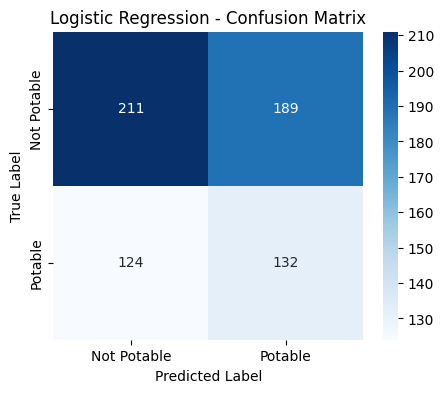

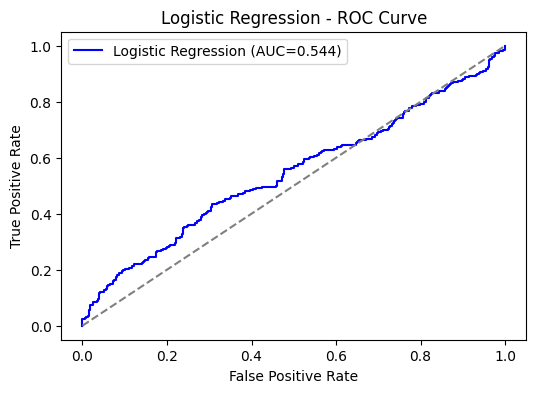

In [16]:
# Initialize model
lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)

# Train the model
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

# Evaluate
evaluate_model(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")

Random Forest


 Results for Random Forest
Accuracy:  0.6601
Precision: 0.6486
Recall:    0.2812
F1-Score:  0.3924
ROC-AUC:   0.6605

Classification Report:
               precision    recall  f1-score   support

         0.0       0.66      0.90      0.76       400
         1.0       0.65      0.28      0.39       256

    accuracy                           0.66       656
   macro avg       0.66      0.59      0.58       656
weighted avg       0.66      0.66      0.62       656




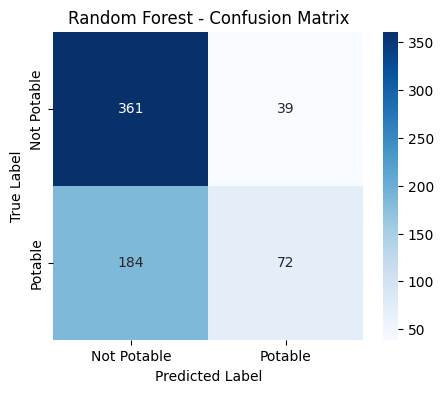

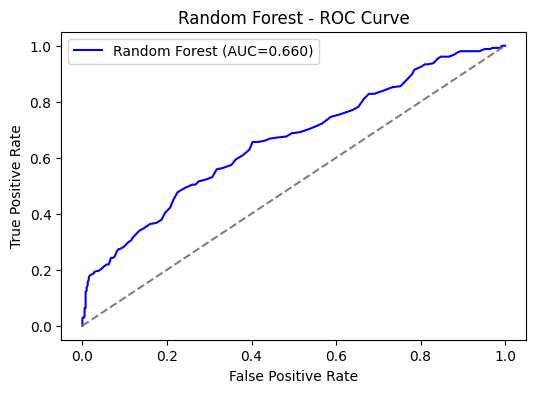

In [17]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

# Train the model
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

# Evaluate
evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest")
print()


XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:46:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Results for XGBoost
Accuracy:  0.6341
Precision: 0.5476
Recall:    0.3594
F1-Score:  0.4340
ROC-AUC:   0.6489

Classification Report:
               precision    recall  f1-score   support

         0.0       0.66      0.81      0.73       400
         1.0       0.55      0.36      0.43       256

    accuracy                           0.63       656
   macro avg       0.61      0.58      0.58       656
weighted avg       0.62      0.63      0.61       656




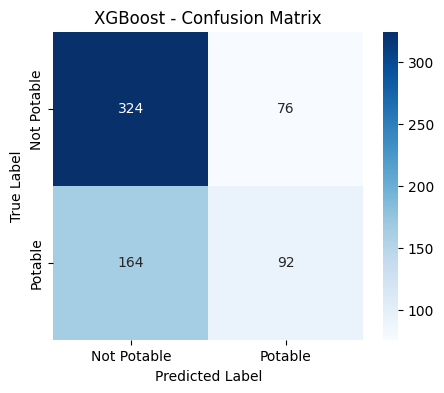

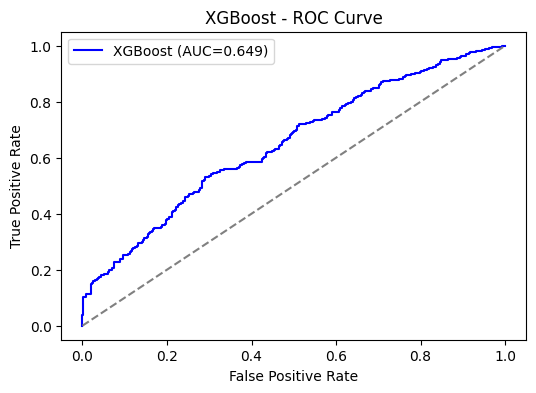

In [18]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

# Evaluate
evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")
print()


Decision Tree


 Results for Decision Tree
Accuracy:  0.5762
Precision: 0.4560
Recall:    0.4453
F1-Score:  0.4506
ROC-AUC:   0.5527

Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.66      0.66       400
         1.0       0.46      0.45      0.45       256

    accuracy                           0.58       656
   macro avg       0.55      0.55      0.55       656
weighted avg       0.57      0.58      0.58       656




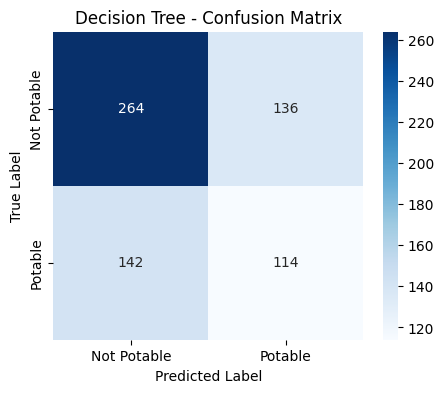

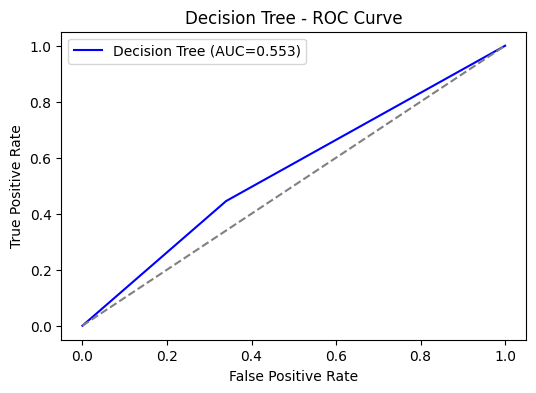

In [19]:
# Initialize model
dt = DecisionTreeClassifier(
    criterion='gini',      # or 'entropy'
    max_depth=None,        # let it grow fully (you can limit depth to prevent overfitting)
    random_state=42,
    class_weight='balanced'
)

# Train the model
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:,1]

# Evaluate
evaluate_model(y_test, y_pred_dt, y_proba_dt, "Decision Tree")
print()


 Results for K-Nearest Neighbors
Accuracy:  0.6113
Precision: 0.5033
Recall:    0.3008
F1-Score:  0.3765
ROC-AUC:   0.5924

Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.81      0.72       400
         1.0       0.50      0.30      0.38       256

    accuracy                           0.61       656
   macro avg       0.57      0.56      0.55       656
weighted avg       0.59      0.61      0.58       656




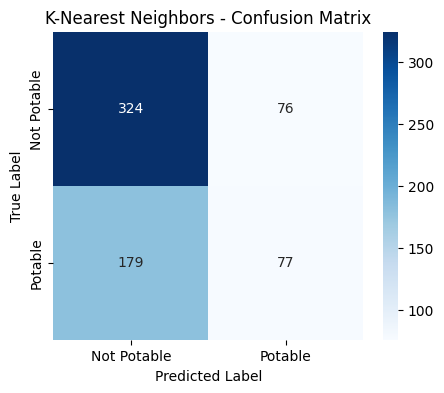

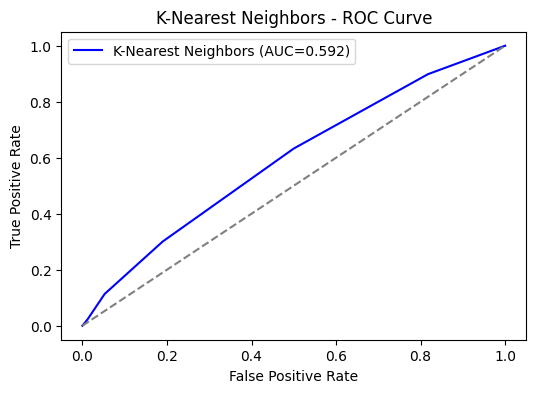

In [20]:
# Initialize KNN model
knn = KNeighborsClassifier(
    n_neighbors=5,   # you can tune this value (3, 5, 7, etc.)
    metric='minkowski',
    p=2              # p=2 means Euclidean distance
)

# Train the model
knn.fit(X_train, y_train)

# Predictions
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:,1]

# Evaluate
evaluate_model(y_test, y_pred_knn, y_proba_knn, "K-Nearest Neighbors")

In [21]:


# Features in correct order
features = [
    "ph", "Hardness", "Solids", "Chloramines", "Sulfate",
    "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"
]

print("Enter 9 water quality values (space separated) in this order:")
print("ph Hardness Solids Chloramines Sulfate Conductivity Organic_carbon Trihalomethanes Turbidity")
print("Example: 7.0 200 21000 7.5 330 420 14 66 3.9")

# Take user input
user_input = list(map(float, input("\nYour values: ").split()))

if len(user_input) != 9:
    print("\n Please enter exactly 9 values.")
else:
    # Convert input to DataFrame with feature names
    sample = pd.DataFrame([user_input], columns=features)

    print("\n Model Predictions:")
    print("-" * 45)

    # Logistic Regression
    pred_lr = lr.predict(sample)[0]
    print(f" Logistic Regression: {' Potable' if pred_lr==1 else ' Not Potable'}")

    # Random Forest
    pred_rf = rf.predict(sample)[0]
    print(f" Random Forest: {' Potable' if pred_rf==1 else ' Not Potable'} (Final Model )")

    # XGBoost
    pred_xgb = xgb.predict(sample)[0]
    print(f" XGBoost: {'Potable' if pred_xgb==1 else ' Not Potable'}")

    # KNN
    pred_knn = knn.predict(sample)[0]
    print(f" KNN: {' Potable' if pred_knn==1 else ' Not Potable'}")

    # Decision Tree
    pred_dt = dt.predict(sample)[0]
    print(f" Decision Tree: {' Potable' if pred_dt==1 else ' Not Potable'}")

    print("-" * 45)

    # Final Decision based on Random Forest (best model)
    print("\n FINAL DECISION (Based on Best Model - Random Forest):")
    if pred_rf == 1:
        print("Water is POTABLE (Safe for drinking)")
    else:
        print(" Water is NOT POTABLE (Unsafe for drinking)")


Enter 9 water quality values (space separated) in this order:
ph Hardness Solids Chloramines Sulfate Conductivity Organic_carbon Trihalomethanes Turbidity
Example: 7.0 200 21000 7.5 330 420 14 66 3.9

Your values: 7.0 200 21000 7.5 330 420 14 66 3.9

 Model Predictions:
---------------------------------------------
 Logistic Regression:  Potable
 Random Forest:  Not Potable (Final Model )
 XGBoost:  Not Potable
 KNN:  Potable
 Decision Tree:  Not Potable
---------------------------------------------

 FINAL DECISION (Based on Best Model - Random Forest):
 Water is NOT POTABLE (Unsafe for drinking)
